In [ ]:
import pandas as pd
import re
from transformers import pipeline
import matplotlib.pyplot as plt

In [30]:
data_opinion = pd.read_json("data_cleaned_opinion.json")
data_history = pd.read_json("data_cleaned_historia.json")

In [33]:
data_opinion['date'] = pd.to_datetime(data_opinion['date_parsed'], errors='coerce')
data_history['date'] = pd.to_datetime(data_history['date_parsed'], errors='coerce')

In [ ]:
def extract_paragraphs(df, root, min_words=5):
    pattern = rf"\b{root}\w*"
    filtered = df[df['full_text'].str.contains(pattern, flags=re.IGNORECASE, na=False, regex=True)].copy()
    filtered['paragraphs'] = filtered['full_text'].str.split(r'\n+')
    rows = []
    for _, row in filtered.iterrows():
        for p in row['paragraphs']:
            if len(p.strip().split()) >= min_words:
                rows.append({
                    'date': row['date'],
                    'title': row['title'],
                    'paragraph': p.strip()
                })
    return pd.DataFrame(rows)

def analyze_sentiment(df_paragraphs):
    sentiment_model = pipeline(
        "sentiment-analysis",
        model="blanchefort/rubert-base-cased-sentiment",
        tokenizer="blanchefort/rubert-base-cased-sentiment"
    )
    df_paragraphs['sentiment'] = df_paragraphs['paragraph'].map(lambda x: sentiment_model(x[:512])[0])
    df_paragraphs['label'] = df_paragraphs['sentiment'].map(lambda x: x['label'])
    df_paragraphs['score'] = df_paragraphs['sentiment'].map(lambda x: x['score'])
    df_paragraphs['year_month'] = df_paragraphs['date'].dt.to_period('M').astype(str)
    return df_paragraphs

def aggregate_sentiment(df_sentiment):
    return df_sentiment.groupby(['year_month', 'label']).size().unstack(fill_value=0)

def full_pipeline(df, root):
    df_extracted = extract_paragraphs(df, root)
    df_analyzed = analyze_sentiment(df_extracted)
    return aggregate_sentiment(df_analyzed)


In [35]:
zelensky = full_pipeline(data_opinion, "Зеленск")
poroshenko = full_pipeline(data_opinion, "Порошенк")
yanukovych = full_pipeline(data_opinion, "Янукович")
putin = full_pipeline(data_opinion, "Путин")
ussr = full_pipeline(data_opinion, "совет|ссср")
mariupol = full_pipeline(data_opinion, "мариупол")
bandera = full_pipeline(data_history, "бандер")

Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0


In [36]:
def plot_sentiment_distribution(df, title):
    df.plot(kind='bar', stacked=True, figsize=(12, 5))
    xticks_idx = np.arange(0, len(df.index), max(len(df.index) // 12, 1))
    plt.xticks(ticks=xticks_idx, labels=df.index[xticks_idx], rotation=45)
    plt.title(f"Monthly sentiment distribution for {title}")
    plt.xlabel("Month")
    plt.ylabel("Number of paragraphs")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.legend(title='Sentiment')
    plt.tight_layout()
    plt.show()

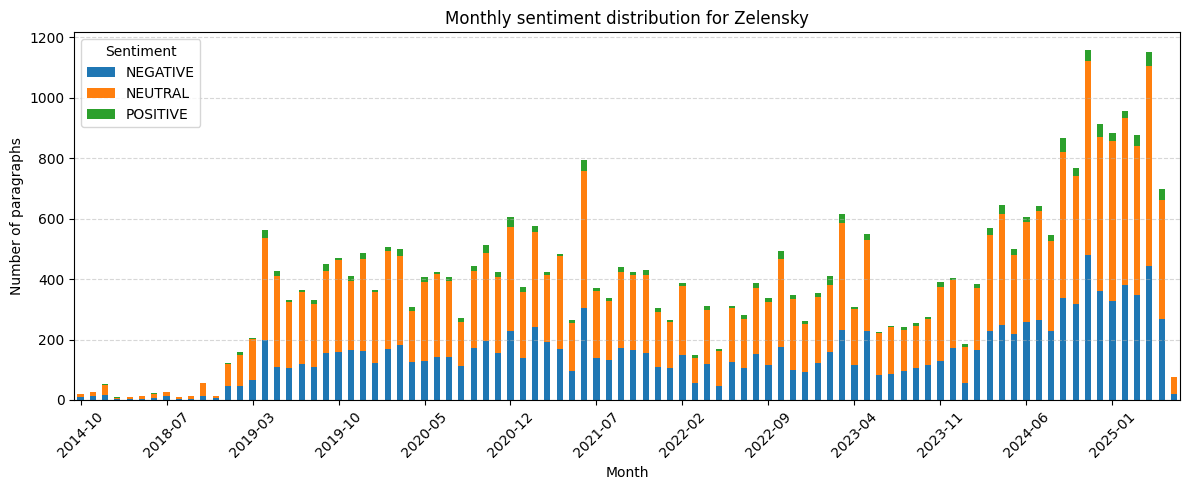

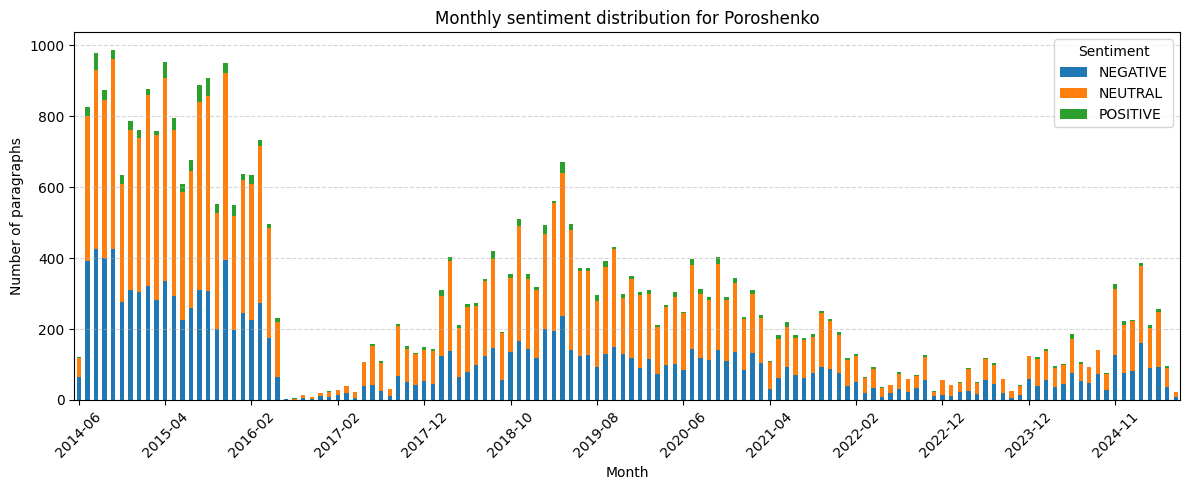

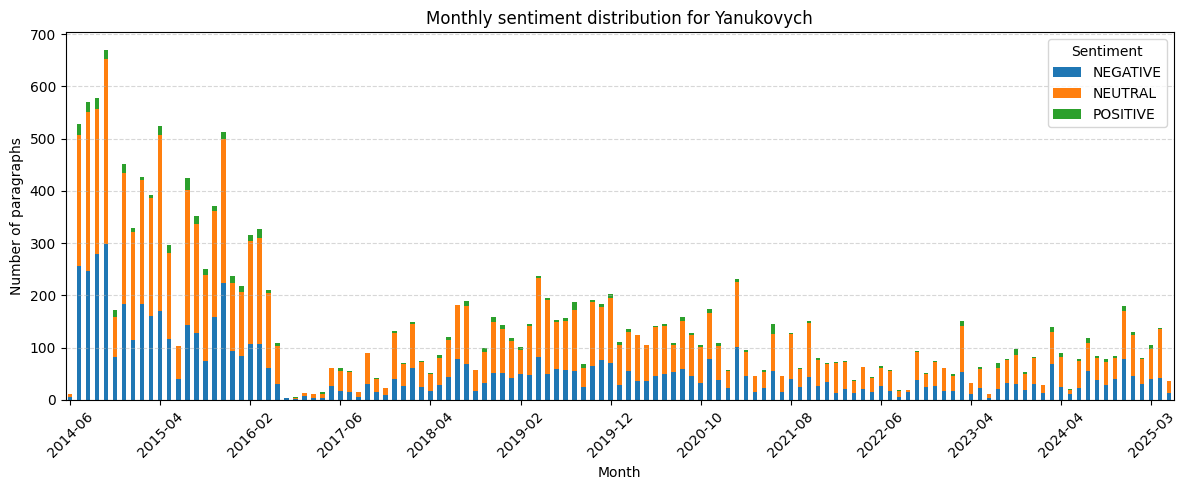

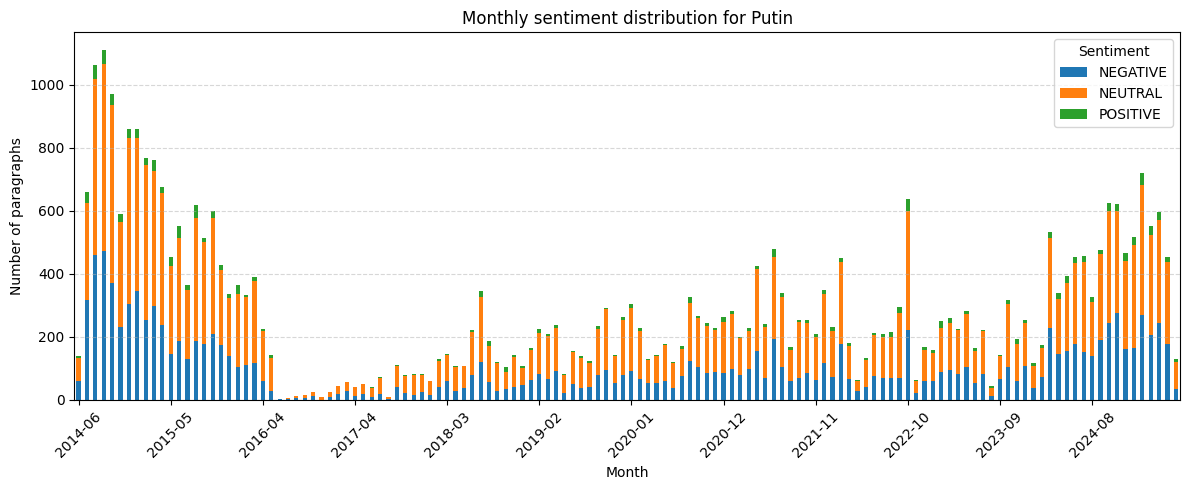

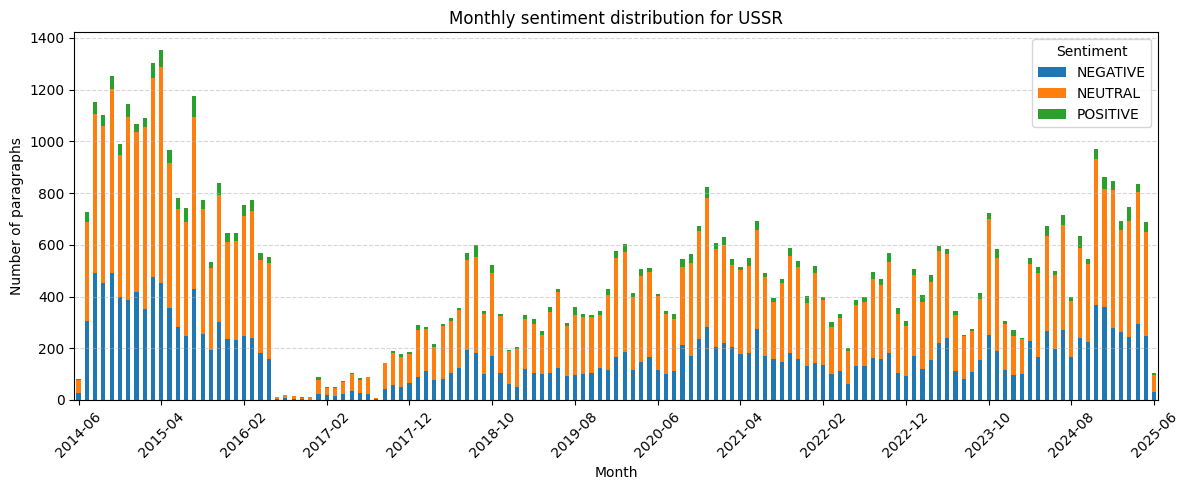

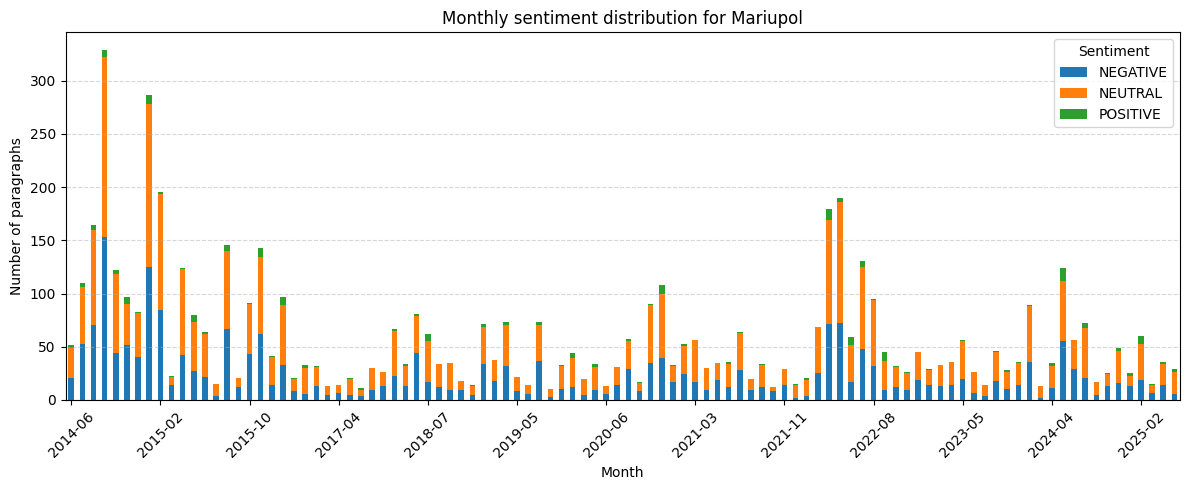

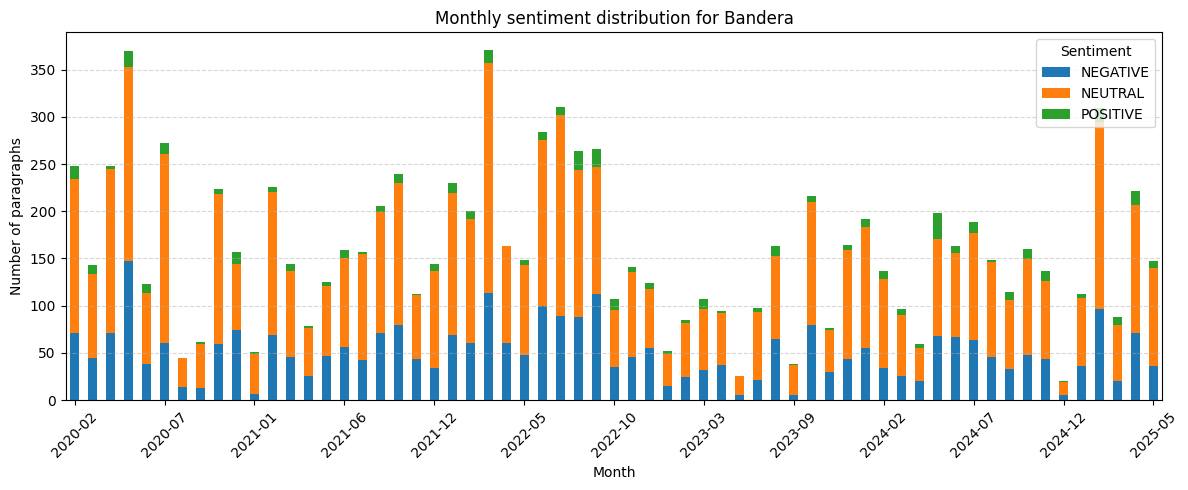

In [37]:
plot_sentiment_distribution(zelensky, "Zelensky")
plot_sentiment_distribution(poroshenko, "Poroshenko")
plot_sentiment_distribution(yanukovych, "Yanukovych")
plot_sentiment_distribution(putin, "Putin")
plot_sentiment_distribution(ussr, "USSR")
plot_sentiment_distribution(mariupol, "Mariupol")
plot_sentiment_distribution(bandera, "Bandera")